In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

import category_encoders as ce

# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '../../'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
# sample_submission.info()

In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [7]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [8]:
# # import nltk
# # from nltk.sentiment.vader import SentimentIntensityAnalyzer
# # import time

# nltk.downloader.download('vader_lexicon')

# sent_analyzer = SentimentIntensityAnalyzer()

# rev1 = "The hotel was very good, I love it!"
# rev2 = "It was just horrible, the worst ever. Fuck it!"

# print(f"review 1:\n{rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}")

# print(f"\nreview 2:\n{rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}")

In [9]:
# data.info()

In [10]:
def get_city(address):
    """ This function extract city and country information from address

    Args:
        address (pandas.Series): The source data
    Returns:
        region string like 'city country'
    """
    # Extract the city and the country
    region = ' '.join(address.split(' ')[-2:])
    if region == 'United Kingdom':
        region = address.split(' ')[-5] + ' ' + region
            
    return region

data['city'] = data['hotel_address'].apply(get_city)

In [11]:
def fill_coordinates_dict(df):
    """ This function collect existing coordinates into dictionary
        for future implementations

    Args:
        df (pandas.DataFrame): The source data that we use for collecting the dictionary
    Returns:
        coordinates_dict (the dictionary of the coordinates of the regions) like {'city country': [latitude, longitude]}
    """
    # Create empty dictionary
    coordinates_dict = dict()
    
    # Go along the rows by indexes
    for idx, row in enumerate(df.index):
        # Extract the city and the country
        region = df['city'].iloc[idx]
           
        # Get the latitude and longitude from the rows
        coordinates = list([df['lat'].iloc[idx], df['lng'].iloc[idx]])
    
        if region not in coordinates_dict.keys():
            coordinates_dict.update({region: coordinates})
            
    return coordinates_dict


def set_coordinates(df, regions_dict):
    """ This function set coordinates for empty cells
        using country and city information

    Args:
        df (pandas.DataFrame): The source dataframe
        regions_dict (the dictionary of the coordinates of the regions) like {'city country': [latitude, longitude]}
    Returns:
        pandas.DataFrame: output dataframe
    """
    # Go along the rows by indexes
    for idx, row in enumerate(df.index):
        # Get the latitude and longitude from the rows
        lat = str(df['lat'].iloc[idx])
        lng = str(df['lng'].iloc[idx])
        
        if lat in ['nan', 'NaN'] or lng in ['nan', 'NaN']:
            region = df['city'].iloc[idx]
            
            if region in regions_dict.keys():
                # Fill the coordinates
                df['lat'].iloc[idx] = regions_dict[region][0]
                df['lng'].iloc[idx] = regions_dict[region][1]
                
    return df

In [12]:
mask = (data['lat'].isnull() & data['lng'].isnull())
data_sample = data.drop(data[mask].index, axis = 0)
data_nans = data[mask]  

coordinates_dict = fill_coordinates_dict(data_sample)
print(coordinates_dict)

data_nans = set_coordinates(data_nans, coordinates_dict)
data = data_sample.append(data_nans, sort=False).reset_index(drop=True)


{'Milan Italy': [4.55331372e+01, 9.1711019], 'Amsterdam Netherlands': [52.3856494, 4.834443], 'Barcelona Spain': [41.3931918, 2.16152], 'London United Kingdom': [51.5241248, -0.1258066], 'Paris France': [48.872174, 2.328075], 'Vienna Austria': [48.191339, 16.3165873]}


/home/freeradical/anaconda3/envs/sf/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
# population = {
#     'Paris France': 2148327,
#     'London United Kingdom': 8908081,
#     'Milan Italy': 1366180, 
#     'Vienna Austria': 1911191,
#     'Barcelona Spain': 1636732,
#     'Amsterdam Netherlands': 860124
# }
# data['population'] = data['city'].map(population)

In [14]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [15]:
# nations_15 = list(data['reviewer_nationality'].value_counts()[:15].index)
# print(nations_15)

# data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in nations_15 else 'other')

# bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
# data['reviewer_nationality'] = bin_encoder.fit_transform(data['reviewer_nationality'])

# ord_encoder = ce.OrdinalEncoder()
# data['reviewer_nationality'] = ord_encoder.fit_transform(data[['reviewer_nationality']])

In [16]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_season'] = data['review_date'].dt.quarter
data['review_month'] = data['review_date'].dt.month
data['review_dayofweek'] = data['review_date'].dt.dayofweek

data['is_day_off'] = data['review_dayofweek'].apply(lambda x: 1 if x > 5 else 0)
data = data.drop(['review_dayofweek'], axis=1)


data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

In [17]:
def collect_tags(df):
    """This function collects the tags information by type and counts
    Args:
        df (pandas.DataFrame): input data

    Returns:
        tags_list (list of the lists): [['Leisure trip', 'Couple', 'Superior Double Room', 'Stayed 1 night'], ... ['Leisure trip', 'Group', 'Large Room', 'Stayed 4 nights']]
        tags_dict (dictionary): the dictionary of tags and their counts like {'Leisure trip': 23452, 'Couple': 67 ... 'Stayed 2 nights': 345}
    """
    # Create empty tags list
    tags_dict = dict()
    tags_list = list()
    # Go along the rows by indexes
    for idx, row in data['tags'].items():
        # Get the tags from the rows
        tags = list(row.replace("[' ", '').replace(" ']", '').split(" ', ' "))
        # Fill the tags list
        tags_list.append(tags)
        for tag in tags:
            if tag not in tags_dict.keys():
                tags_dict.update({tag: 1})
            else:
                tags_dict[tag] += 1
                
    return tags_list, tags_dict

In [18]:
tg_list, tg_dict = collect_tags(data)
print(len(tg_dict))
print(tg_list[5:15])

2428
[['Business trip', 'Solo traveler', 'Standard Double or Twin Room', 'Stayed 1 night'], ['Leisure trip', 'Couple', 'Queen Room', 'Stayed 1 night'], ['Business trip', 'Solo traveler', 'Executive Room', 'Stayed 3 nights', 'Submitted from a mobile device'], ['Group', 'Double or Twin Room', 'Stayed 1 night'], ['Couple', 'Standard Triple Room', 'Stayed 2 nights', 'Submitted from a mobile device'], ['Leisure trip', 'Couple', 'Superior Double Room', 'Stayed 1 night'], ['Leisure trip', 'Group', 'Large Room', 'Stayed 4 nights'], ['Leisure trip', 'Group', 'Superior King Room', 'Stayed 2 nights'], ['Leisure trip', 'Couple', 'Double or Twin Room', 'Stayed 3 nights'], ['Leisure trip', 'Couple', 'Junior Suite', 'Stayed 2 nights']]


In [19]:
def most_freq_tag_stayed(tags):
    """This function find the most frequent tag with keyword 'Stayed..'

    Args:
        df (pandas.DataFrame): input data

    Returns:
        tag: tag value
        count: quantity in dataset
    """
    max_tag = ''
    max_count = 0
    for tag, count in tags.items():
        # Go along the items
        
        if 'stayed' in tag.lower():
            if count > max_count:
                max_count = count
                max_tag = tag

    return max_tag, max_count

print(most_freq_tag_stayed(tg_dict))

('Stayed 1 night', 193645)


In [20]:
def create_purpose_feature(tags):
    """This function find the tags information about purpose of the trip
    Args:
        tags (list of string): input tags list
    Returns:
        purpose(int): 2 - if the purpose is leisure, 1 - if business, 0 - na
        tags: croped input tags list
    """
    purpose = 0
    for idx, tag in enumerate(tags):
        if 'trip' in tag:
            purpose = tags.pop(idx)
            if 'leisure' in purpose.lower():
                purpose = 2
            elif 'business' in purpose.lower():
                purpose = 1
    return purpose, tags

In [21]:
def create_nights_feature(tags):
    """This function find the tags information about the number of nights staying at hotel
    Args:
        tags (list of string): input tags list
    Returns:
        nights(int): number of nights
        tags: croped input tags list
    """
    nights = 1
    for idx, tag in enumerate(tags):
        if 'Stayed' in tag:
            nights = int(tags.pop(idx).split(' ')[1])
            
    return nights, tags

In [22]:
def create_mobile_feature(tags):
    """This function find the tags information about submitting from a mobile device
    Args:
        tags (list of string): input tags list
    Returns:
        mobile(int): 1 - submitted from mobive, 0 - no
        tags: croped input tags list
    """
    mobile = 0
    for idx, tag in enumerate(tags):
        if 'mobile' in tag:
            tags.pop(idx)
            mobile = 1
    return mobile, tags

In [23]:
def create_tags_features(tag_lst):
    """This function parse the tags information about purpose of a trip , number of nights staying, room type etc.
    Args:
        df (pandas.DataFrame): input data
        tags (list of lists of tags): like [['Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights'], ... ['Leisure trip', 'Group', 'Triple Room', 'Stayed 1 night']]
    Returns:
        features_list (formated features list): like [[1, 'Solo traveler', 'Standard Double or Twin Room', 1, 0], ... [0, 'Group', 'Double or Twin Room', 1, 0]]
    """
    # Create empty features list
    features_list = list()
    
    # Go along the items
    for idx, tags in enumerate(tag_lst):
        
        # Extract trip purpose
        trip_purpose, tags = create_purpose_feature(tags)
    
        # Extract nights number     
        nights, tags = create_nights_feature(tags)
        
        # Extract mobile option    
        mobile, tags = create_mobile_feature(tags)
        
        # Extract travellers type   
        if len(tags):
            travellers = tags.pop(0) 
        
        # Extract room type    
        if len(tags):
            room_type = tags.pop(0) 
        
        #Fill formated features list
        features_list.append([trip_purpose, travellers, room_type, nights, mobile])
        
    return features_list

In [24]:
features_list = create_tags_features(tg_list)
features_list[100:110]

[[2, 'Solo traveler', 'Deluxe Double Room', 2, 0],
 [2, 'Group', 'Classic Double or Twin Room', 5, 0],
 [2, 'Couple', 'Superior Double or Twin Room', 4, 0],
 [2, 'Solo traveler', 'Deluxe Double Room', 1, 0],
 [1, 'Solo traveler', 'Single Room', 3, 0],
 [2, 'Solo traveler', 'Superior Twin Room', 1, 0],
 [1, 'Couple', 'Deluxe Single Room', 2, 0],
 [2, 'Group', 'Nhow Double or Twin Room', 2, 1],
 [2, 'Couple', 'Superior Queen Suite with Sofa', 12, 1],
 [2, 'Family with young children', 'Superior Double Room', 1, 1]]

In [25]:
features_df = pd.DataFrame(
    data = features_list,
    columns= ['trip_purpose', 'travellers', 'room_type', 'nights', 'mobile']
)
data = pd.concat([data, features_df], axis=1)
data = data.drop(['tags'], axis=1)


In [26]:
data[['trip_purpose', 'travellers', 'room_type', 'nights', 'mobile']].nunique()

trip_purpose       3
travellers         7
room_type       2390
nights            31
mobile             2
dtype: int64

In [27]:
romms_type_31 = list(data['room_type'].value_counts()[:31].index)

print(romms_type_31)

data['room_type'] = data['room_type'].apply(lambda x: x if x in romms_type_31 else 'other')

['Double Room', 'Standard Double Room', 'Superior Double Room', 'Deluxe Double Room', 'Double or Twin Room', 'Standard Double or Twin Room', 'Classic Double Room', 'Superior Double or Twin Room', '2 rooms', 'Standard Twin Room', 'Single Room', 'Twin Room', 'Executive Double Room', 'Classic Double or Twin Room', 'Superior Twin Room', 'Deluxe Double or Twin Room', 'Club Double Room', 'Queen Room', 'Deluxe King Room', 'Superior Queen Room', 'Standard Single Room', 'Junior Suite', 'Triple Room', 'Superior Room', 'Classic Room', 'Superior King Room', 'Standard Room', 'Deluxe Room', 'Standard Queen Room', 'Double Guest Room', 'Deluxe Single Room']


In [28]:
# nltk.downloader.download('vader_lexicon')

# sent_analyzer = SentimentIntensityAnalyzer()

# rev1 = "The hotel was very good, I love it!"
# rev2 = "It was just horrible, the worst ever. Fuck it!"

# print(f"review 1:\n{rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}")

# print(f"\nreview 2:\n{rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}")

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [30]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

bin_encoder = ce.BinaryEncoder(cols=['travellers']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['travellers'])
data = pd.concat([data, type_bin], axis=1)

bin_encoder = ce.BinaryEncoder(cols=['room_type']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['room_type'])
data = pd.concat([data, type_bin], axis=1)

# bin_encoder = ce.BinaryEncoder(cols=['review_month']) # указываем столбец для кодирования
# type_bin = bin_encoder.fit_transform(data['review_month'])
# data = pd.concat([data, type_bin], axis=1)


# ord_encoder = ce.OrdinalEncoder()
# data_bin = ord_encoder.fit_transform(data[['nights']])
# data = pd.concat([data, data_bin], axis=1)


# encoder = ce.OneHotEncoder(cols=['type']) # указываем столбец для кодирования
# type_bin = encoder.fit_transform(clothing['type'])
# clothing = pd.concat([clothing, type_bin], axis=1)

/home/freeradical/anaconda3/envs/sf/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [31]:
data.drop(['additional_number_of_scoring', 'review_date', 'review_season', 'review_month'], axis = 1, inplace=True)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [33]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns = list(data.columns[data.dtypes == 'object'])
print(object_columns)
data.drop(object_columns, axis = 1, inplace=True)

['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'city', 'travellers', 'room_type']


In [34]:
# col_names = data.columns

# # инициализируем нормализатор MinMaxScaler
# mm_scaler = preprocessing.MinMaxScaler()

# # копируем исходный датасет
# data = mm_scaler.fit_transform(data)

# # Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
# data = pd.DataFrame(data, columns=col_names)


<AxesSubplot:>

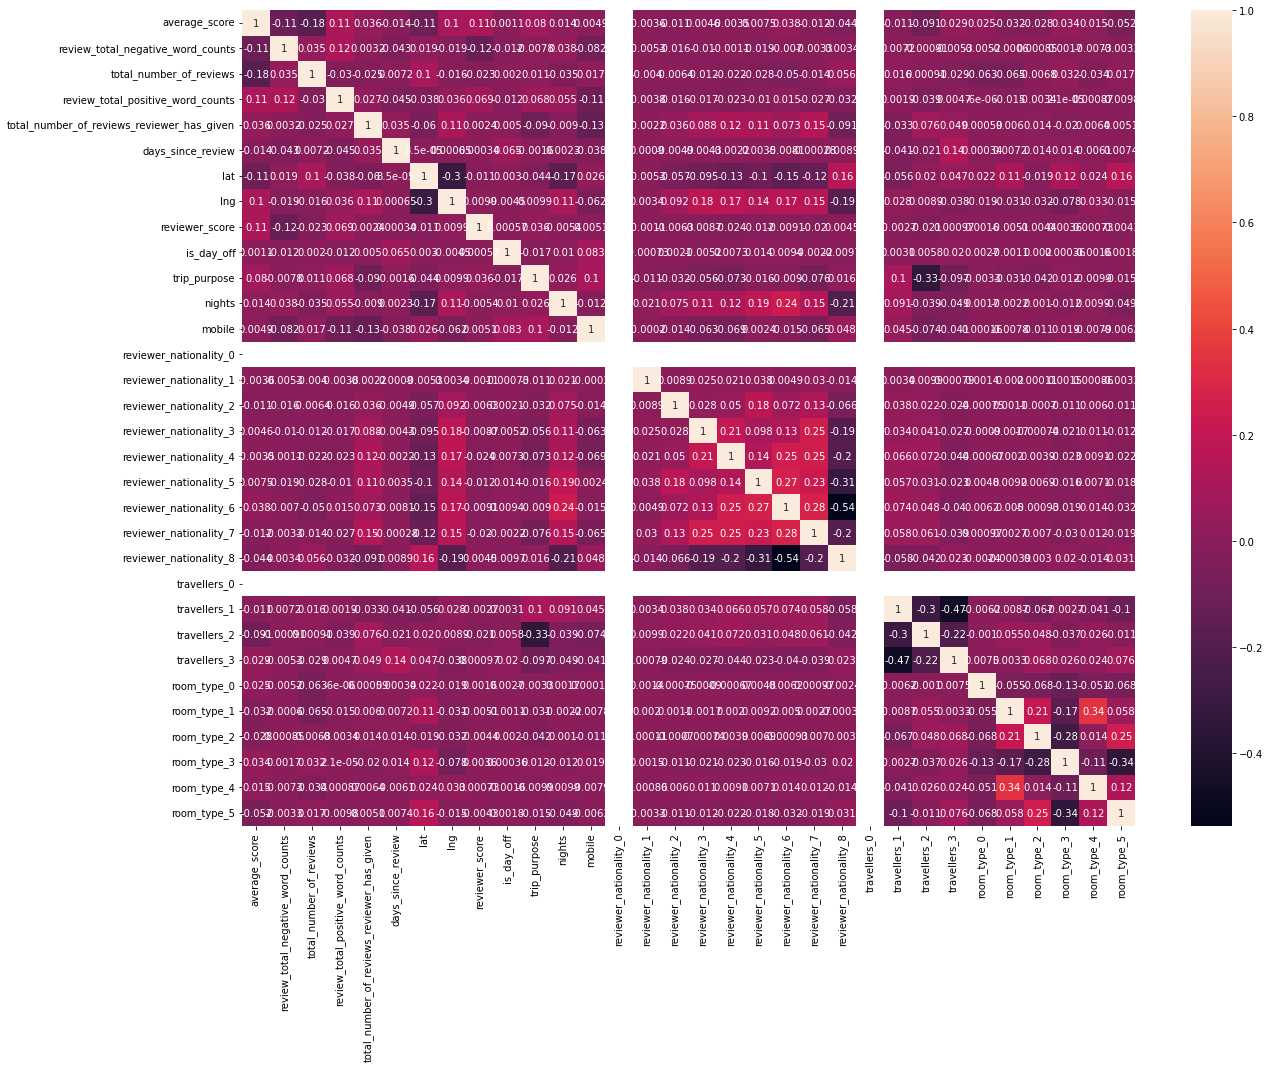

In [35]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [35]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [37]:
# # непрерывные признаки
# num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts']

# # категориальные признаки
# cat_cols = ['average_score', 'lat']

In [38]:
# y=y.astype('int')


# from sklearn.feature_selection import chi2 # хи-квадрат

# imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

In [36]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [37]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 33), (386803, 33), (386803, 32), (309442, 32), (77361, 32))

In [38]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [39]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [40]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9322793474748255


In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)